# Project 1 - Building an Agentic Corrective RAG System with LangGraph

This project will cover a full hands-on workflow and demonstration of how to build an Agentic Corrective RAG (CRAG) System with LangGraph

The idea would be to implement the workflow taking inspiration from the [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884) research paper.

The main challenge of RAG systems include:

- Poor Retrieval can lead to issues in LLM response generation
- Bad retrieval or lack of information in the vector database can also lead to out of context or hallucinated answers

The idea is to couple a RAG system with a few checks in place and perform web searches if there is a lack of relevant context documents to the given user query as follows:

![](https://i.imgur.com/uhybMhT.png)


We can build this as an agentic RAG system by having a specific functionality step as a node in the graph and use LangGraph to implement it. Key steps in the node will include prompts being sent to LLMs to perform specific tasks as seen in the detailed workflow below:

![](https://i.imgur.com/eV87ZwX.gif)


## Install OpenAI, and LangChain dependencies

In [1]:
# %pip install langchain==0.2.0
# %pip install langchain-openai==0.1.7
# %pip install langchain-community==0.2.0
# %pip install langgraph==0.1.1
# %pip install langchain-chroma==0.1.1

%pip install langchain
%pip install langchain-ollama
%pip install langchain-community
%pip install langgraph
%pip install langchain-chroma


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached tokenizers-0.20.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached tokenizers-0.20.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokeniz

In [1]:
!curl -fsSL https://ollama.com/install.sh | sh
!ollama pull gemma3n:e4b
!ollama pull llama3.2
!ollama pull nomic-embed-text

>>> Installing ollama to /usr/local


>>> Downloading Linux amd64 bundle
######################################################################## 100.0%  9.0%                   17.0%     48.4%
>>> Creating ollama user...
>>> Adding ollama user to render group...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> Enabling and starting ollama service...
Created symlink /etc/systemd/system/default.target.wants/ollama.service → /etc/systemd/system/ollama.service.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling 38e8dcc30df4:   0% ▕                  ▏ 135 KB/7.5 GB                  pulling manifest 
pulling 38e8dcc30df4:   1% ▕                  ▏  51 MB/7.5 GB                  pulling manifest 
pulling 38e8dcc30df4:   1% ▕                  ▏  93 MB/7.5 GB                  pulling manifest 

## Enter Tavily Search API Key

In [1]:
from getpass import getpass

TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

## Setup Environment Variables

In [2]:
import os

os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

### Ollama Embedding Models

LangChain enables us to access Ollama Embedding Models, like "nomic-embed-text" which is a lightweight and high-performance embedding model.

In [3]:
from langchain_ollama import OllamaEmbeddings

ollama_embed_model = OllamaEmbeddings(model='nomic-embed-text')

### Load and Chunk Documents

In [4]:
import pdfplumber
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Path to your PDF file
pdf_filepath = "a-practical-guide-to-building-agents.pdf"

# Extract text from PDF
docs = []
with pdfplumber.open(pdf_filepath) as pdf:
    full_text = ""
    for page in pdf.pages:
        full_text += page.extract_text() or ""  # Extract text from each page, handle None

    # Create a single Document object with the full text
    docs.append(Document(
        page_content=full_text,
        metadata={
            'source': pdf_filepath,
            'title': pdf_filepath.split('/')[-1]  # Use filename as title
        }
    ))

# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P2' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P2' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value


In [5]:
len(chunked_docs)

21

In [6]:
chunked_docs[:3]

[Document(metadata={'source': 'a-practical-guide-to-building-agents.pdf', 'title': 'a-practical-guide-to-building-agents.pdf'}, page_content="A practical\nguide to\nbuilding agentsContents\nWhat is an agent? 4\nWhen should you build an agent? 5\nAgent design foundations 7\nGuardrails 24\nConclusion 32\n2 Practical guide to building agentsIntroduction\nLarge language models are becoming increasingly capable of handling complex, multi-step tasks.\nAdvances in reasoning, multimodality, and tool use have unlocked a new category of LLM-powered\nsystems known as agents.\n\nThis guide is designed for product and engineering teams exploring how to build their first agents,\ndistilling insights from numerous customer deployments into practical and actionable best\npractices. It includes frameworks for identifying promising use cases, clear patterns for designing\nagent logic and orchestration, and best practices to ensure your agents run safely, predictably,\nand effectively.\nAfter reading thi

### Create a Vector DB and persist on disk

Here we initialize a connection to a Chroma vector DB client, and also we want to save to disk, so we simply initialize the Chroma client and pass the directory where we want the data to be saved to.

In [7]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings - takes < 30s on Colab
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name='rag_agents_db',
                                  embedding=ollama_embed_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./rag_agents_db")

### Setup a Vector Database Retriever

Here we use the following retrieval strategy:

- Similarity with Threshold Retrieval


### Similarity with Threshold Retrieval

We use cosine similarity here and retrieve the top 3 similar documents based on the user input query and also introduce a cutoff to not return any documents which are below a certain similarity threshold

In [8]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                                                        search_kwargs={"k": 3,
                                                                       "score_threshold": 0.3})

In [9]:
query = "what is an agent?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'source': 'a-practical-guide-to-building-agents.pdf', 'title': 'a-practical-guide-to-building-agents.pdf'}, page_content="A practical\nguide to\nbuilding agentsContents\nWhat is an agent? 4\nWhen should you build an agent? 5\nAgent design foundations 7\nGuardrails 24\nConclusion 32\n2 Practical guide to building agentsIntroduction\nLarge language models are becoming increasingly capable of handling complex, multi-step tasks.\nAdvances in reasoning, multimodality, and tool use have unlocked a new category of LLM-powered\nsystems known as agents.\n\nThis guide is designed for product and engineering teams exploring how to build their first agents,\ndistilling insights from numerous customer deployments into practical and actionable best\npractices. It includes frameworks for identifying promising use cases, clear patterns for designing\nagent logic and orchestration, and best practices to ensure your agents run safely, predictably,\nand effectively.\nAfter reading thi

In [10]:
query = "when to build an agent?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'source': 'a-practical-guide-to-building-agents.pdf', 'title': 'a-practical-guide-to-building-agents.pdf'}, page_content="A practical\nguide to\nbuilding agentsContents\nWhat is an agent? 4\nWhen should you build an agent? 5\nAgent design foundations 7\nGuardrails 24\nConclusion 32\n2 Practical guide to building agentsIntroduction\nLarge language models are becoming increasingly capable of handling complex, multi-step tasks.\nAdvances in reasoning, multimodality, and tool use have unlocked a new category of LLM-powered\nsystems known as agents.\n\nThis guide is designed for product and engineering teams exploring how to build their first agents,\ndistilling insights from numerous customer deployments into practical and actionable best\npractices. It includes frameworks for identifying promising use cases, clear patterns for designing\nagent logic and orchestration, and best practices to ensure your agents run safely, predictably,\nand effectively.\nAfter reading thi

## Create a Query Retrieval Grader

Here we will use an LLM itself to grade if any retrieved document is relevant to the given question - Answer will be either `yes` or `no`

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_ollama import ChatOllama


# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM for grading
llm = ChatOllama(model="llama3.2", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
query = "what is an agent?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

A practical
guide to
building agentsContents
What is an agent? 4
When should you build an agent? 5
Agent design foundations 7
Guardrails 24
Conclusion 32
2 Practical guide to building agentsIntroduction
Large language models are becoming increasingly capable of handling complex, multi-step tasks.
Advances in reasoning, multimodality, and tool use have unlocked a new category of LLM-powered
systems known as agents.

This guide is designed for product and engineering teams exploring how to build their first agents,
distilling insights from numerous customer deployments into practical and actionable best
practices. It includes frameworks for identifying promising use cases, clear patterns for designing
agent logic and orchestration, and best practices to ensure your agents run safely, predictably,
and effectively.
After reading this guide, you’ll have the foundational knowledge you need to confidently start
building your first agent.
3 A practical guide to building agentsWhat is an
agent?

In [52]:
query = "when to build an agent?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

A practical
guide to
building agentsContents
What is an agent? 4
When should you build an agent? 5
Agent design foundations 7
Guardrails 24
Conclusion 32
2 Practical guide to building agentsIntroduction
Large language models are becoming increasingly capable of handling complex, multi-step tasks.
Advances in reasoning, multimodality, and tool use have unlocked a new category of LLM-powered
systems known as agents.

This guide is designed for product and engineering teams exploring how to build their first agents,
distilling insights from numerous customer deployments into practical and actionable best
practices. It includes frameworks for identifying promising use cases, clear patterns for designing
agent logic and orchestration, and best practices to ensure your agents run safely, predictably,
and effectively.
After reading this guide, you’ll have the foundational knowledge you need to confidently start
building your first agent.
3 A practical guide to building agentsWhat is an
agent?

GRADE: None

2
 name="Weather agent",

3
 instructions="You are a helpful agent who can talk to users about the
4
 weather.",

5
 tools=[get_weather],

6 )
7 A practical guide to building agentsSelecting your models
Different models have different strengths and tradeoffs related to task complexity, latency, and
cost. As we’ll see in the next section on Orchestration, you might want to consider using a variety
of models for different tasks in the workflow.

Not every task requires the smartest model—a simple retrieval or intent classification task may be
handled by a smaller, faster model, while harder tasks like deciding whether to approve a refund
may benefit from a more capable model.

An approach that works well is to build your agent prototype with the most capable model for
every task to establish a performance baseline. From there, try swapping in smaller models to see
if they still achieve acceptable results. This way, you don’t prematurely limit the agent’s abilities,
and you c

## Build a QA RAG Chain

We will now connect our retriever to an LLM and build our QA RAG Chain

In [12]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize connection with GPT-4o
model = ChatOllama(model="gemma3n:e4b", temperature=0)
# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    model
      |
    StrOutputParser()
)

In [56]:
query = "what is an agent?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

An agent is a system that independently accomplishes tasks on your behalf. Unlike conventional software that streamlines and automates workflows for users, agents can perform the same workflows on the user's behalf with a high degree of independence. 

Here are the core characteristics of an agent:

*   **Leverages an LLM:** It uses a large language model to manage workflow execution and make decisions.
*   **Workflow Management:** It recognizes when a workflow is complete and can proactively correct its actions if needed. In case of failure, it can halt execution and transfer control back to the user.
*   **Tool Access:** It has access to various tools to interact with external systems, both to gather context and to take actions. It dynamically selects the appropriate tools based on the workflow's current state, always operating within clearly defined guardrails.

In essence, agents are well-suited for workflows where traditional deterministic and rule-based approaches are insufficien

In [57]:
query = "when to build an agent?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

According to the provided context, you should build an agent when you need a system that can independently accomplish tasks on your behalf. This is particularly useful for workflows that require a sequence of steps to achieve a user's goal, such as resolving customer service issues, booking reservations, or generating reports. 

The context also suggests building an agent when you want to automate complex, multi-step tasks that leverage the capabilities of large language models (LLMs) for reasoning, multimodal understanding, and tool use. 

In essence, build an agent when you want to automate workflows and tasks that require independent decision-making and action, going beyond simple chatbots or single-turn LLM applications.


## Create a Query Rephraser

We will now build a query rephraser which will use an LLM to rephrase the input user query into a better version which is optimized for web search

In [13]:
# LLM for question rewriting
llm = ChatOllama(model="llama3.2", temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)
# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

In [59]:
query = "what are agent design foundations?"
question_rewriter.invoke({"question": query})

'## Improved Question:\n\n**"What are the fundamental principles and design patterns in agent-based systems?"**\n\n## Reasoning for Improvement:\n\nThe original question "what are agent design foundations?" is quite vague. While understandable, it\'s not the kind of query someone would typically use when searching online. \n\nHere\'s a breakdown of why the revised question is better for web search:\n\n* **More Specific Keywords:**  Instead of just "foundations," the revised question uses more specific and commonly used terms like "fundamental principles" and "design patterns." These are terms developers and researchers are likely to use when searching for information on agent design.\n* **Clarifies the Context:**  Adding "agent-based systems" clarifies the domain.  It removes ambiguity and ensures the search results are focused on the intended topic.\n* **Action-Oriented:** The question implies a desire to understand *how* agent systems are designed, which is a more actionable intent t

## Load Web Search Tool

Here we will be using the [Tavily API](https://tavily.com/#api) for our web searches

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

## Build Agentic RAG components

Here we will build the key components of our Agentic Corrective RAG System as per the workflow below:

![](https://i.imgur.com/uhybMhT.png)



### Graph State

Used to store and represent the state of the agent graph as we traverse through various nodes

In [15]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### Retrieve function for retrieval from Vector DB

This will be used to get relevant context documents from the vector database

In [ ]:
# Define other nodes (simplified for demonstration)

def retrieve(state: GraphState) -> GraphState:
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question, "web_search_needed": "No"}

### Grade documents

This will be used to determine whether the retrieved documents are relevant to the question by using an LLM Grader

Sets the `web_search_needed` flag as `Yes` if at least one document is not contextually relevant and sets it as `No` if all documents are contextually relevant to the given user query

In [ ]:
# Define grade documents node with web_search_needed update

def grade_documents(state: GraphState) -> GraphState:
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search_needed = "No"

    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": documents}
            )
            grade = score.binary_score  # Get the grade as 'yes' or 'no'
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

### Rewrite query

This will be used to rewrite the input query to produce a better question optimized for web search using an LLM

In [ ]:
# Define query rewrite node
def rewrite_query(state: GraphState) -> GraphState:
    print("---REWRITE QUERY---")
    question = state["question"]
    # Mock query rewrite
    rewritten_question = f"rephrased {question}"
    return {"question": rewritten_question, "documents": state["documents"], "web_search_needed": "Yes"}

### Web Search

This will be used to search the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG

In [19]:
from langchain.schema import Document

# Define the web search node
def web_search(state: GraphState) -> GraphState:
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Perform web search
    search_results = tv_search.invoke(question)

    # Handle search results
    if isinstance(search_results, str):
        web_results = Document(page_content=search_results)
    else:
        try:
            web_results = "\n\n".join([d["content"] for d in search_results])
            web_results = Document(page_content=web_results)
        except (TypeError, KeyError):
            web_results = Document(page_content="No relevant web results found.")

    documents.append(web_results)
    return {"documents": documents, "question": question, "web_search_needed": "Yes"}

### Generate Answer

Standard LLM Response generation from query and context documents in a RAG system

In [ ]:
def generate(state: GraphState) -> GraphState:
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation, "question": question, "documents": documents, "web_search_needed": state["web_search_needed"]}

### Decide to Generate

This will be used as a conditional function which will check the `web_search_needed` flag and decide if a web search is needed or a response should be generated and return the function name to be called

In [21]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

### Build the Agent Graph

Here we will use LangGraph and build the agent as a graph

In [22]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

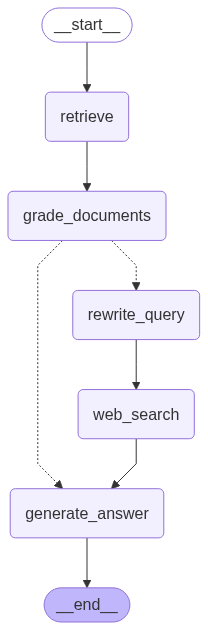

In [23]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

## Test the Agentic CRAG System

In [24]:
query = "what is an agent?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---


---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [26]:
display(Markdown(response['generation']))

An agent is a system that independently accomplishes tasks on your behalf. Unlike conventional software that streamlines and automates workflows for users, agents can perform the same workflows on the user's behalf with a high degree of independence. 

Here are the core characteristics of an agent:

*   **Leverages an LLM:** It uses a large language model to manage workflow execution and make decisions.
*   **Workflow Management:** It recognizes when a workflow is complete and can proactively correct its actions if needed. In case of failure, it can halt execution and transfer control back to the user.
*   **Tool Access:** It has access to various tools to interact with external systems, both to gather context and to take actions. It dynamically selects the appropriate tools based on the workflow's current state, always operating within clearly defined guardrails.

In essence, agents are well-suited for workflows where traditional deterministic and rule-based approaches are insufficient.

In [29]:
query = "what is CrewAI agent?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [30]:
display(Markdown(response['generation']))

CrewAI is a lean, lightning-fast Python framework built entirely from scratch, independent of LangChain or other agent frameworks. It empowers developers to create autonomous AI agents tailored to specific scenarios.

In CrewAI, an `Agent` is an autonomous unit that can:

*   Perform specific tasks
*   Make decisions based on its role and goal
*   Use tools to accomplish objectives
*   Communicate and collaborate with other agents
*   Maintain memory of interactions
*   Delegate tasks when allowed

An agent is a fundamental component designed to perform specific tasks within a multi-agent system.

In [27]:
query = "what is orchestration?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---


---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [28]:
display(Markdown(response['generation']))

Orchestration refers to patterns in building applications, particularly in the context of AI agents, where workflow execution is managed. It involves coordinating multiple components, which can be single agents or a network of agents, to achieve a desired outcome. 

Here's a breakdown of the key aspects:

*   **Single-agent systems:** A single model uses tools and instructions to execute workflows in a loop.
*   **Multi-agent systems:** Workflow execution is distributed across multiple coordinated agents.
*   **Manager pattern:** A central "manager" agent delegates tasks to specialized agents, ensuring a smooth and unified user experience.
*   **Run:**  An orchestration approach typically uses a loop to allow agents to operate until an exit condition is met (e.g., tool calls, a specific output, errors).
*   **Declarative vs. non-declarative graphs:** Some frameworks use graphs to define workflows, but this can become complex for dynamic workflows.

In essence, orchestration provides a way to manage and coordinate the interactions of different parts of an application to accomplish complex tasks.